# Introduction

This notebook demonstrates the use of the LAMMPS interface to MatGL developed by AdvancedSoft. To install, please clone LAMMPS from AdvancedSoft's Github repo. It is recommended that you use cmake, especially if you are on Apple Silicon Macs. Below are a sequence of instructions that worked for me. Modify as necessary.

```
git clone https://github.com/advancesoftcorp/lammps.git
cd lammps
git checkout based-on-lammps_2Jun2022
mkdir build
cd build
cmake -C ../cmake/presets/basic.cmake -D BUILD_SHARED_LIBS=on -D LAMMPS_EXCEPTIONS=on -D PKG_PYTHON=on -D PKG_ML-M3GNET=on -D PKG_EXTRA-COMPUTE=on -D PKG_EXTRA-FIX=on -D PKG_MANYBODY=on -D PKG_EXTRA-DUMP=on -D PKG_MOLECULE=on ../cmake
cmake --build .
make install
```

After installation, your lmp executable should be in your `$HOME/.local/bin` directory. You will need to add that to your PATH if it is not already there. You may also need to adjust your library paths if needed.

Upon running this notebook, if you encounter an error about DFTD3 and you do not need dispersion corrections, I recommend you simply comment out the `from dftd3.ase import DFTD3` line in your `$HOME/.local/share/potentials/M3GNET/matgl_driver.py` file. DFTD3 is a pain to install.

In [ ]:
from __future__ import annotations

import glob
import os
from datetime import timedelta

import pandas as pd
import seaborn as sns

n_cpus = 1

HOME_DIR = os.environ["HOME"]

We will first create our test structure - a simple ZrO with 12 atoms.

In [ ]:
data = """

      12  atoms
       2  atom types

 0.00000000e+00  5.14996644e+00  xlo xhi
 0.00000000e+00  5.14996644e+00  ylo yhi
 0.00000000e+00  5.14996644e+00  zlo zhi

 Atoms

       1        1  0.000000e+00  0.000000e+00  0.000000e+00
       2        1  0.000000e+00  2.574983e+00  2.574983e+00
       3        1  2.574983e+00  0.000000e+00  2.574983e+00
       4        1  2.574983e+00  2.574983e+00  0.000000e+00
       5        2  3.862475e+00  3.862475e+00  3.862475e+00
       6        2  1.287492e+00  3.862475e+00  3.862475e+00
       7        2  3.862475e+00  1.287492e+00  1.287492e+00
       8        2  1.287492e+00  1.287492e+00  1.287492e+00
       9        2  1.287492e+00  3.862475e+00  1.287492e+00
      10        2  3.862475e+00  3.862475e+00  1.287492e+00
      11        2  1.287492e+00  1.287492e+00  3.862475e+00
      12        2  3.862475e+00  1.287492e+00  3.862475e+00

 Masses

       1  9.122400e+01 # Zr
       2  1.599940e+01 # O

"""

with open("dat.lammps", "w") as f:
    f.write(data)

In [ ]:
run_stats = []

for x in [1, 2, 4, 8, 16, 32, 64, 128]:
    modified_script = f"""
units         metal
boundary      p p p
atom_style    atomic

pair_style    m3gnet {HOME_DIR}/.local/share/lammps/potentials/M3GNET

read_data     ./dat.lammps
replicate     {x} 1 1
pair_coeff    * *  M3GNet-MP-2021.2.8-DIRECT-PES  Zr O  # MatGL will be called

dump          myDump all custom 10 xyz.lammpstrj id element x y z
dump_modify   myDump sort id element Zr O

thermo_style  custom step time cpu pe ke etotal temp press vol density
thermo        10

velocity      all create 300.0 12345
fix           myEnse all npt temp 300.0 300.0 0.1 aniso 1.0 1.0 1.0
timestep      1.0e-3
run           100
"""

    outfile = f"ZrO_{x}.out"
    # Write the modified script to a temporary file
    with open("lammps.in", "w") as f:
        f.write(modified_script)
    os.environ["OMP_NUM_THREADS"] = f"{n_cpus}"
    lammps_command = f"lmp < lammps.in > {outfile}"
    r = %timeit -n 1 -r 1 -o subprocess.run(lammps_command, shell=True)
    with open(outfile) as f:
        for line in f:
            if "Total wall time" in line:
                _, hours, minutes, seconds = line.split(":")
                walltime = timedelta(
                    hours=int(hours),
                    minutes=int(minutes),
                    seconds=int(seconds)).total_seconds()
    run_stats.append((x*12, r.average, walltime))

/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


6.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


9.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


17.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


31.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


1min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


3min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/bin/sh: lscpu: command not found
/Users/shyue/repos/matgl/matgl/apps/pes.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_mean = torch.tensor(data_mean) if data_mean is not None else torch.zeros(1)
/Users/shyue/repos/matgl/matgl/apps/pes.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data_std = torch.tensor(data_std) if data_std is not None else torch.ones(1)


8min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
results = pd.DataFrame(run_stats, columns=["natoms", "run_time", "wall_time"])

<Axes: xlabel='natoms', ylabel='wall_time'>

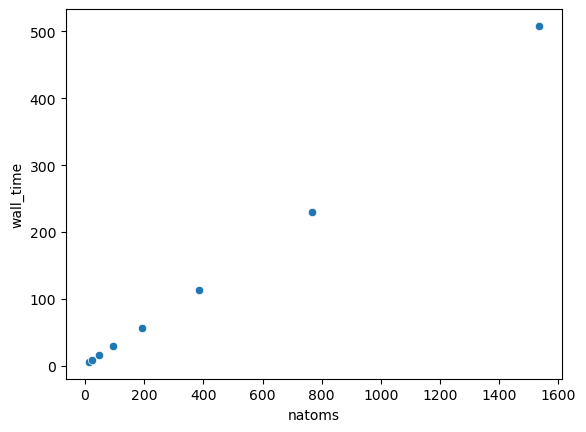

In [ ]:
sns.scatterplot(data=results, x="natoms", y="wall_time")

In [ ]:
# Perform some cleanup

os.remove("lammps.in")
for fn in glob.glob("ZnO*.out") + glob.glob("*.lammps"):
    os.remove(fn)